# Chapter 8: Testing Set Overfitting

This notebook implements the concepts from Chapter 8 of "Machine Learning for Asset Managers" by Marcos Lopez de Prado.

**Key Topics:**
- The False Strategy Theorem
- Selection Bias under Multiple Testing (SBuMT)
- The Deflated Sharpe Ratio (DSR)
- Type I and Type II Errors
- Minimum Backtest Length

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
from ml4am.testing_set_overfitting import (
    expected_max_sharpe_ratio,
    simulate_max_sharpe_distribution,
    deflated_sharpe_ratio,
    probabilistic_sharpe_ratio,
    get_z_statistic,
    type1_error_probability,
    type2_error_probability,
    get_theta,
    min_backtest_length,
    haircut_sharpe_ratio,
    DeflatedSharpeRatio
)

## 1. The Problem of Backtest Overfitting

Backtesting is a historical simulation of how an investment strategy would have performed in the past. However, backtesting suffers from **selection bias under multiple testing**:

- Researchers run many backtests on historical data
- They present only the best-performing strategies
- This leads to overfitted strategies that won't perform well out-of-sample

The key insight is that **even with purely random strategies**, the maximum Sharpe Ratio observed will increase with the number of trials.

## 2. The False Strategy Theorem

The **False Strategy Theorem** states that the expected value of the maximum Sharpe Ratio is greater than the expected value of any individual Sharpe Ratio, even when all strategies have zero true performance.

$$E[\max\{SR\}] \approx (1-\gamma)\Phi^{-1}(1-1/N) + \gamma\Phi^{-1}(1-(Ne)^{-1})$$

where $\gamma \approx 0.5772$ is the Euler-Mascheroni constant, and $N$ is the number of trials.

In [6]:
# Demonstrate how expected max SR increases with number of trials
n_trials_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

expected_max_srs = [expected_max_sharpe_ratio(n, mean_sr=0, std_sr=1) 
                   for n in n_trials_range]

results_df = pd.DataFrame({
    'n_trials': n_trials_range,
    'expected_max_sr': expected_max_srs
})

print("Expected Maximum Sharpe Ratio vs Number of Trials")
print("="*50)
print(results_df.to_string(index=False))

Expected Maximum Sharpe Ratio vs Number of Trials
 n_trials  expected_max_sr
        1         0.000000
        2         0.519755
        5         1.192594
       10         1.574598
       20         1.900708
       50         2.276303
      100         2.530603
      200         2.765524
      500         3.052528
     1000         3.255122


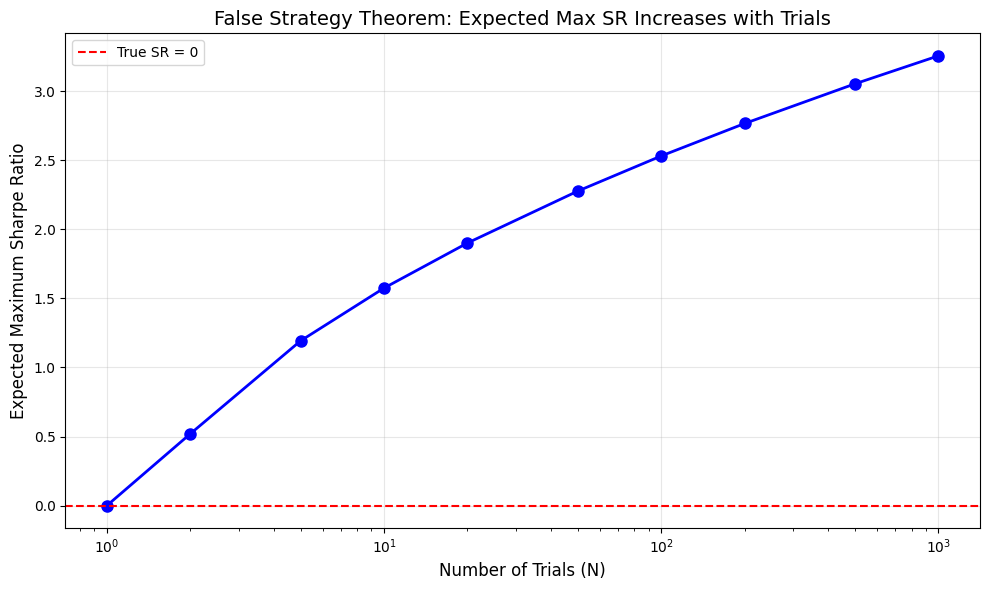

In [7]:
# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.plot(n_trials_range, expected_max_srs, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Number of Trials (N)', fontsize=12)
plt.ylabel('Expected Maximum Sharpe Ratio', fontsize=12)
plt.title('False Strategy Theorem: Expected Max SR Increases with Trials', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', label='True SR = 0')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Monte Carlo Simulation of Maximum Sharpe Ratios

Let's verify the False Strategy Theorem empirically through simulation.

In [8]:
# Simulate distributions of maximum SRs
n_sims = 10000
n_trials_list = [1, 5, 10, 50, 100]

sim_results = simulate_max_sharpe_distribution(
    n_sims=n_sims,
    n_trials_list=n_trials_list,
    mean_sr=0,
    std_sr=1,
    random_state=42
)

sim_results.head()

,max_sr,n_trials
0,0.496714,1
1,-0.138264,1
2,0.647689,1
3,1.523030,1
4,-0.234153,1


In [9]:
# Compare simulated vs theoretical expected max SR
comparison = sim_results.groupby('n_trials')['max_sr'].mean().reset_index()
comparison.columns = ['n_trials', 'simulated_mean']
comparison['theoretical'] = [expected_max_sharpe_ratio(n) for n in comparison['n_trials']]
comparison['error_%'] = 100 * (comparison['simulated_mean'] - comparison['theoretical']) / comparison['theoretical']

print("Comparison: Simulated vs Theoretical Expected Max SR")
print("="*60)
print(comparison.to_string(index=False))

Comparison: Simulated vs Theoretical Expected Max SR
 n_trials  simulated_mean  theoretical   error_%
        1       -0.002136     0.000000      -inf
        5        1.240766     1.192594  4.039303
       10        1.584343     1.574598  0.618889
       50        2.257357     2.276303 -0.832318
      100        2.512924     2.530603 -0.698592


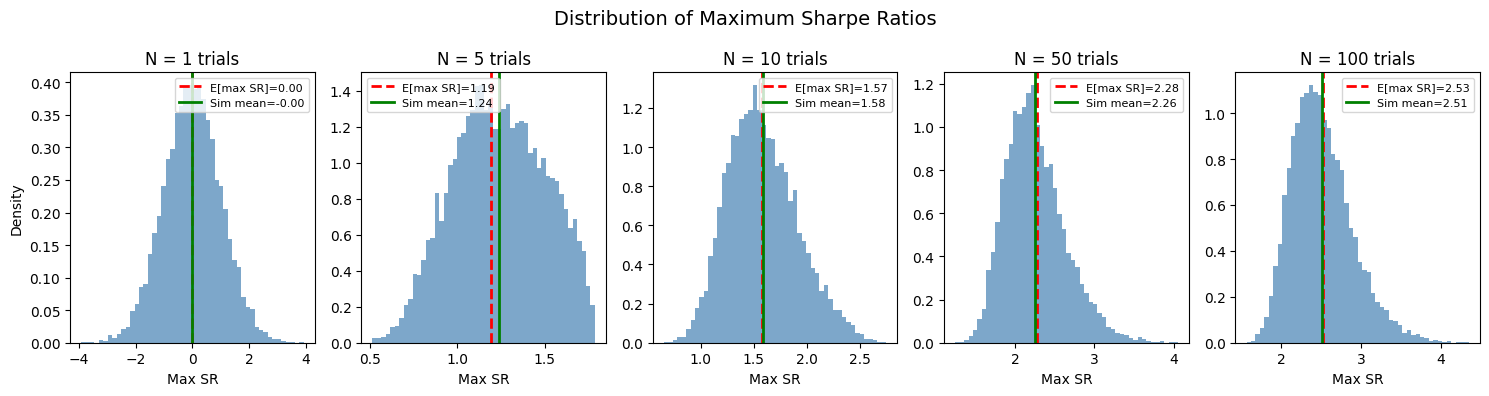

In [10]:
# Visualize the distributions
fig, axes = plt.subplots(1, len(n_trials_list), figsize=(15, 4))

for i, n_trials in enumerate(n_trials_list):
    data = sim_results[sim_results['n_trials'] == n_trials]['max_sr']
    theoretical = expected_max_sharpe_ratio(n_trials)
    
    axes[i].hist(data, bins=50, density=True, alpha=0.7, color='steelblue')
    axes[i].axvline(x=theoretical, color='red', linestyle='--', linewidth=2, 
                    label=f'E[max SR]={theoretical:.2f}')
    axes[i].axvline(x=data.mean(), color='green', linestyle='-', linewidth=2,
                    label=f'Sim mean={data.mean():.2f}')
    axes[i].set_title(f'N = {n_trials} trials')
    axes[i].set_xlabel('Max SR')
    axes[i].legend(fontsize=8)

axes[0].set_ylabel('Density')
plt.suptitle('Distribution of Maximum Sharpe Ratios', fontsize=14)
plt.tight_layout()
plt.show()

## 4. The Deflated Sharpe Ratio (DSR)

The **Deflated Sharpe Ratio** corrects for:
1. **Non-normality**: Skewness and kurtosis of returns
2. **Sample length**: Short backtests are less reliable
3. **Multiple testing**: Selection bias from running many trials

DSR computes the probability that the observed SR is statistically significant after these adjustments.

$$DSR = \Phi\left(\frac{(\hat{SR} - SR^*)\sqrt{T-1}}{\sqrt{1-\gamma_1\hat{SR}+(\gamma_2-1)/4 \cdot \hat{SR}^2}}\right)$$

where:
- $\hat{SR}$ is the observed Sharpe Ratio
- $SR^*$ is the expected maximum SR under null (from False Strategy Theorem)
- $T$ is the sample length
- $\gamma_1$ is skewness, $\gamma_2$ is kurtosis

In [11]:
# Example: Evaluating a backtest result
sr_observed = 1.5      # Observed annualized SR
n_obs = 252 * 3        # 3 years of daily data
n_trials = 100         # Researcher tried 100 different strategies
skewness = -0.5        # Returns are negatively skewed
kurtosis = 5.0         # Fat tails

# Compute expected max SR under null
sr_benchmark = expected_max_sharpe_ratio(n_trials, mean_sr=0, std_sr=1)

# Compute DSR
dsr = deflated_sharpe_ratio(
    sr_observed=sr_observed,
    sr_benchmark=sr_benchmark,
    n_obs=n_obs,
    n_trials=n_trials,
    skewness=skewness,
    kurtosis=kurtosis
)

# Compute PSR (without multiple testing adjustment)
psr = probabilistic_sharpe_ratio(
    sr_observed=sr_observed,
    sr_benchmark=0,
    n_obs=n_obs,
    skewness=skewness,
    kurtosis=kurtosis
)

print("Backtest Evaluation")
print("="*50)
print(f"Observed Sharpe Ratio:     {sr_observed:.2f}")
print(f"Number of observations:    {n_obs}")
print(f"Number of trials:          {n_trials}")
print(f"Skewness:                  {skewness}")
print(f"Kurtosis:                  {kurtosis}")
print(f"")
print(f"Expected Max SR (null):    {sr_benchmark:.3f}")
print(f"Probabilistic SR (PSR):    {psr:.3f}")
print(f"Deflated SR (DSR):         {dsr:.3f}")
print(f"")
print(f"Interpretation: {'Strategy is likely genuine' if dsr > 0.95 else 'Strategy may be overfitted'}")

Backtest Evaluation
Observed Sharpe Ratio:     1.50
Number of observations:    756
Number of trials:          100
Skewness:                  -0.5
Kurtosis:                  5.0

Expected Max SR (null):    2.531
Probabilistic SR (PSR):    1.000
Deflated SR (DSR):         0.000

Interpretation: Strategy may be overfitted


## 5. Using the DeflatedSharpeRatio Class

For convenience, we provide a class interface that handles all the computations.

In [12]:
# Initialize evaluator with number of trials
dsr_evaluator = DeflatedSharpeRatio(n_trials=100)
print(dsr_evaluator)

DeflatedSharpeRatio(n_trials=100, expected_max_sr=2.5306)


In [13]:
# Evaluate a backtest
result = dsr_evaluator.evaluate(
    sr_observed=1.5,
    n_obs=756,
    skewness=-0.5,
    kurtosis=5.0
)

print("Evaluation Results:")
for key, value in result.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Evaluation Results:
  dsr: 0.0000
  psr: 1.0000
  expected_max_sr: 2.5306
  z_statistic: -14.1591
  is_significant: False


## 6. Impact of Multiple Testing

Let's visualize how the number of trials affects the DSR for a given observed Sharpe Ratio.

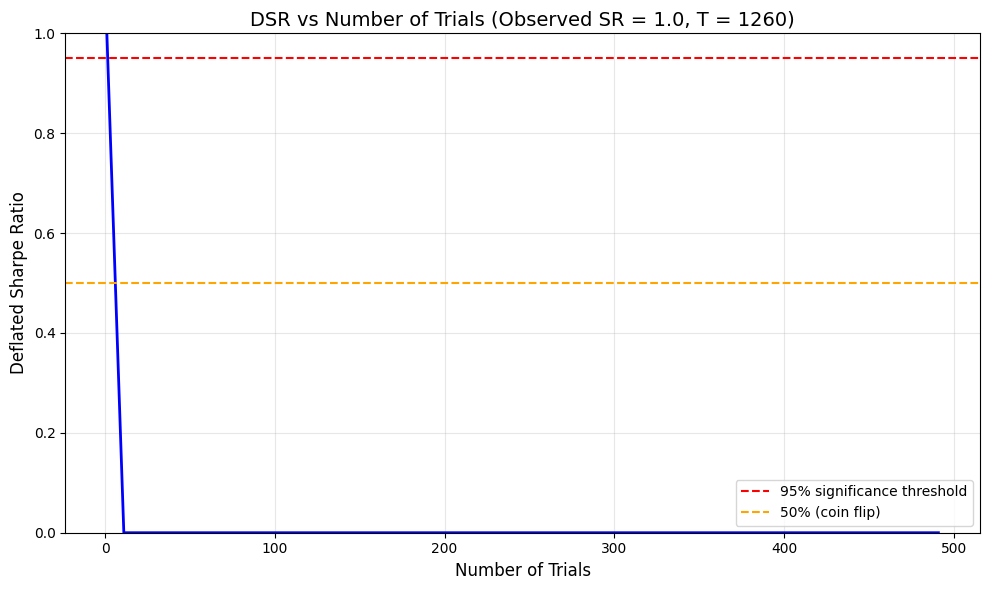

In [14]:
# How DSR changes with number of trials
sr_observed = 1.0
n_obs = 252 * 5  # 5 years

n_trials_range = np.arange(1, 501, 10)
dsr_values = []

for n in n_trials_range:
    sr_bench = expected_max_sharpe_ratio(n)
    dsr = deflated_sharpe_ratio(sr_observed, sr_bench, n_obs, n)
    dsr_values.append(dsr)

plt.figure(figsize=(10, 6))
plt.plot(n_trials_range, dsr_values, 'b-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% significance threshold')
plt.axhline(y=0.5, color='orange', linestyle='--', label='50% (coin flip)')
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Deflated Sharpe Ratio', fontsize=12)
plt.title(f'DSR vs Number of Trials (Observed SR = {sr_observed}, T = {n_obs})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

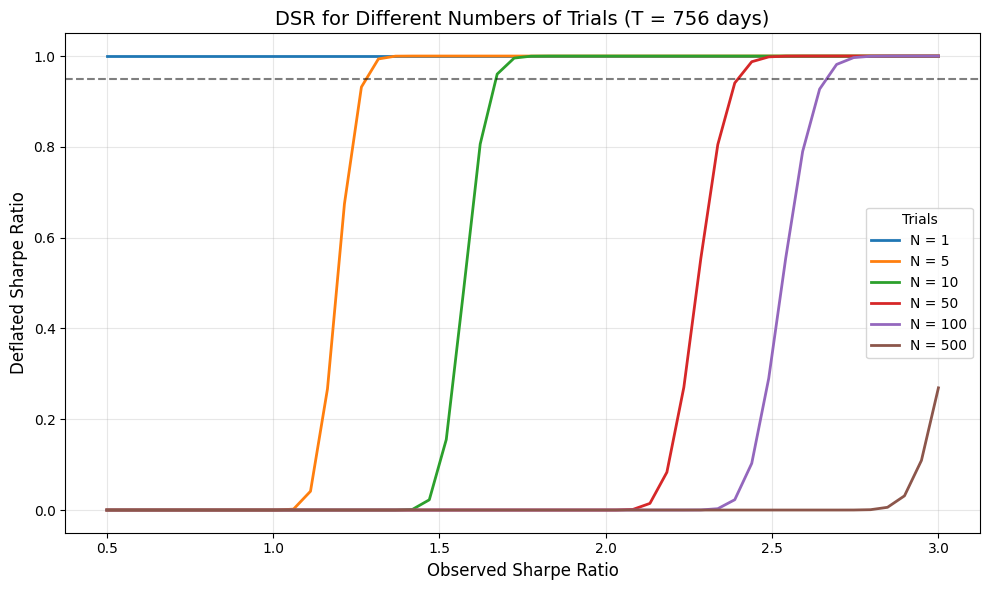

In [15]:
# DSR surface: SR vs N_trials
sr_range = np.linspace(0.5, 3.0, 50)
n_trials_range = np.array([1, 5, 10, 50, 100, 500])
n_obs = 252 * 3

plt.figure(figsize=(10, 6))

for n_trials in n_trials_range:
    dsr_values = []
    sr_bench = expected_max_sharpe_ratio(n_trials)
    for sr in sr_range:
        dsr = deflated_sharpe_ratio(sr, sr_bench, n_obs, n_trials)
        dsr_values.append(dsr)
    plt.plot(sr_range, dsr_values, label=f'N = {n_trials}', linewidth=2)

plt.axhline(y=0.95, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Observed Sharpe Ratio', fontsize=12)
plt.ylabel('Deflated Sharpe Ratio', fontsize=12)
plt.title(f'DSR for Different Numbers of Trials (T = {n_obs} days)', fontsize=14)
plt.legend(title='Trials')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Type I and Type II Errors

- **Type I Error (α)**: False positive - concluding a strategy works when it doesn't
- **Type II Error (β)**: False negative - missing a genuine strategy

Under multiple testing, Type I error increases while Type II error may also be affected.

In [16]:
# Type I error under multiple testing
z_stat = 1.96  # Single test alpha = 0.05
n_trials_range = [1, 5, 10, 20, 50, 100, 500, 1000]

type1_errors = [type1_error_probability(z_stat, k) for k in n_trials_range]

print("Type I Error (Familywise) vs Number of Trials")
print("="*50)
print(f"Single test significance level: alpha = {stats.norm.cdf(-z_stat):.4f}")
print()
for n, err in zip(n_trials_range, type1_errors):
    print(f"N = {n:4d} trials: alpha_k = {err:.4f} ({err*100:.1f}%)")

Type I Error (Familywise) vs Number of Trials
Single test significance level: alpha = 0.0250

N =    1 trials: alpha_k = 0.0250 (2.5%)
N =    5 trials: alpha_k = 0.1189 (11.9%)
N =   10 trials: alpha_k = 0.2237 (22.4%)
N =   20 trials: alpha_k = 0.3973 (39.7%)
N =   50 trials: alpha_k = 0.7180 (71.8%)
N =  100 trials: alpha_k = 0.9205 (92.0%)
N =  500 trials: alpha_k = 1.0000 (100.0%)
N = 1000 trials: alpha_k = 1.0000 (100.0%)


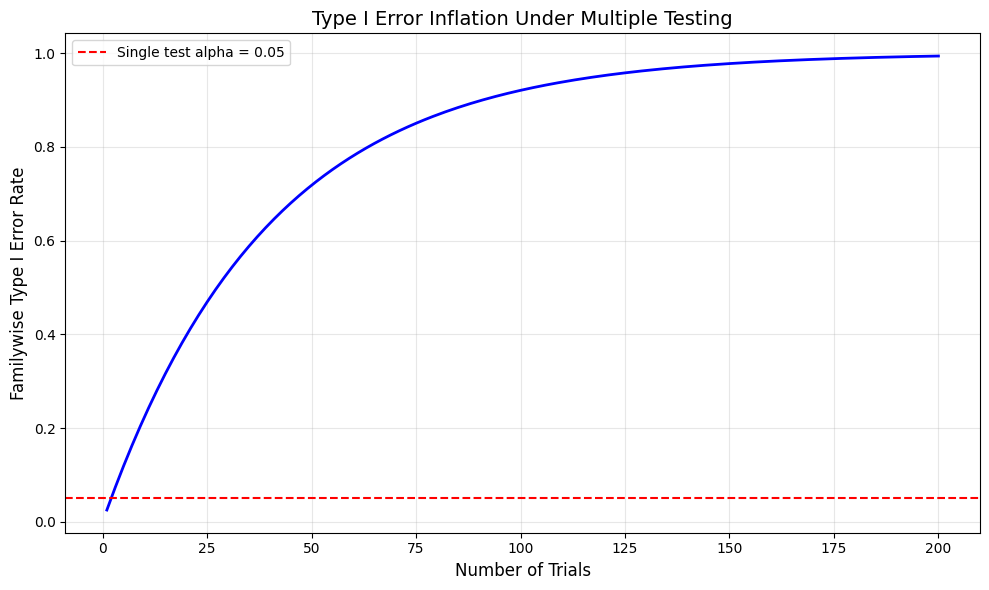

In [17]:
# Visualize Type I error inflation
n_trials_range = np.arange(1, 201)
type1_errors = [type1_error_probability(1.96, k) for k in n_trials_range]

plt.figure(figsize=(10, 6))
plt.plot(n_trials_range, type1_errors, 'b-', linewidth=2)
plt.axhline(y=0.05, color='r', linestyle='--', label='Single test alpha = 0.05')
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Familywise Type I Error Rate', fontsize=12)
plt.title('Type I Error Inflation Under Multiple Testing', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Minimum Backtest Length

How long should a backtest be to reliably detect a strategy with a given Sharpe Ratio?

In [18]:
# Minimum backtest length for different target SRs
target_srs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
confidence = 0.95

print(f"Minimum Backtest Length (95% confidence)")
print("="*50)
print(f"{'Target SR':>12} {'Min Days':>12} {'Min Years':>12}")
print("-"*40)

for sr in target_srs:
    min_days = min_backtest_length(sr, confidence=confidence)
    min_years = min_days / 252
    print(f"{sr:>12.1f} {min_days:>12d} {min_years:>12.1f}")

Minimum Backtest Length (95% confidence)
   Target SR     Min Days    Min Years
----------------------------------------
         0.5           14          0.1
         1.0            6          0.0
         1.5            4          0.0
         2.0            4          0.0
         2.5            3          0.0
         3.0            3          0.0


In [19]:
# Impact of non-normality on minimum backtest length
sr_target = 1.0
kurtosis_values = [3, 5, 7, 10]  # Normal = 3

print(f"Impact of Kurtosis on Minimum Backtest Length (SR = {sr_target})")
print("="*50)
print(f"{'Kurtosis':>12} {'Min Days':>12} {'Min Years':>12}")
print("-"*40)

for kurt in kurtosis_values:
    min_days = min_backtest_length(sr_target, kurtosis=kurt)
    min_years = min_days / 252
    print(f"{kurt:>12.0f} {min_days:>12d} {min_years:>12.1f}")

Impact of Kurtosis on Minimum Backtest Length (SR = 1.0)
    Kurtosis     Min Days    Min Years
----------------------------------------
           3            6          0.0
           5            7          0.0
           7            8          0.0
          10           10          0.0


## 9. Sharpe Ratio Haircut

The haircut adjusts the observed Sharpe Ratio to account for multiple testing and autocorrelation.

In [20]:
# Apply haircut for different scenarios
sr_observed = 2.0
n_obs = 252 * 3

scenarios = [
    (1, 0),      # 1 trial, no autocorrelation
    (10, 0),     # 10 trials
    (100, 0),    # 100 trials
    (100, 0.1),  # 100 trials with autocorrelation
    (100, 0.2),  # Higher autocorrelation
]

print(f"Sharpe Ratio Haircut (Observed SR = {sr_observed}, T = {n_obs})")
print("="*60)
print(f"{'N Trials':>10} {'Autocorr':>10} {'Haircut SR':>12} {'Reduction %':>12}")
print("-"*50)

for n_trials, ac in scenarios:
    sr_haircut = haircut_sharpe_ratio(sr_observed, n_obs, n_trials, ac)
    reduction = 100 * (1 - sr_haircut / sr_observed)
    print(f"{n_trials:>10d} {ac:>10.1f} {sr_haircut:>12.3f} {reduction:>12.1f}%")

Sharpe Ratio Haircut (Observed SR = 2.0, T = 756)
  N Trials   Autocorr   Haircut SR  Reduction %
--------------------------------------------------
         1        0.0        2.000          0.0%
        10        0.0        1.943          2.9%
       100        0.0        1.908          4.6%
       100        0.1        1.717         14.1%
       100        0.2        1.541         23.0%


## 10. Practical Example: Evaluating Multiple Strategies

Let's simulate a realistic scenario where a researcher has tested many strategies.

In [21]:
# Simulate a researcher who tested 50 strategies
np.random.seed(42)
n_strategies = 50
n_obs = 252 * 5  # 5 years of daily data

# Generate random strategies (most are noise, a few might be real)
# True SRs: mostly 0, with a few positive
true_srs = np.concatenate([np.zeros(45), np.array([0.5, 0.7, 0.8, 1.0, 1.2])])
np.random.shuffle(true_srs)

# Observed SRs = true SR + estimation noise
estimation_noise = np.random.normal(0, 1/np.sqrt(n_obs), n_strategies)
observed_srs = true_srs + estimation_noise * np.sqrt(252)  # Annualize

# Evaluate each strategy
dsr_evaluator = DeflatedSharpeRatio(n_trials=n_strategies)

results = []
for i, (true_sr, obs_sr) in enumerate(zip(true_srs, observed_srs)):
    eval_result = dsr_evaluator.evaluate(obs_sr, n_obs)
    results.append({
        'strategy': i + 1,
        'true_sr': true_sr,
        'observed_sr': obs_sr,
        'psr': eval_result['psr'],
        'dsr': eval_result['dsr'],
        'is_significant': eval_result['is_significant']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('observed_sr', ascending=False)

In [22]:
# Show top 10 strategies by observed SR
print("Top 10 Strategies by Observed Sharpe Ratio")
print("="*70)
print(results_df.head(10).to_string(index=False))

Top 10 Strategies by Observed Sharpe Ratio
 strategy  true_sr  observed_sr  psr           dsr  is_significant
       44      1.2     1.972122  1.0  1.590376e-10           False
        6      1.0     1.706978  1.0  2.634369e-38           False
       19      0.8     1.133559  1.0 5.503013e-220           False
       25      0.0     1.046814  1.0 1.181249e-269           False
       18      0.7     0.844986  1.0  0.000000e+00           False
       12      0.0     0.681662  1.0  0.000000e+00           False
       41      0.0     0.656931  1.0  0.000000e+00           False
       36      0.0     0.583015  1.0  0.000000e+00           False
       26      0.0     0.478959  1.0  0.000000e+00           False
       43      0.0     0.424855  1.0  0.000000e+00           False


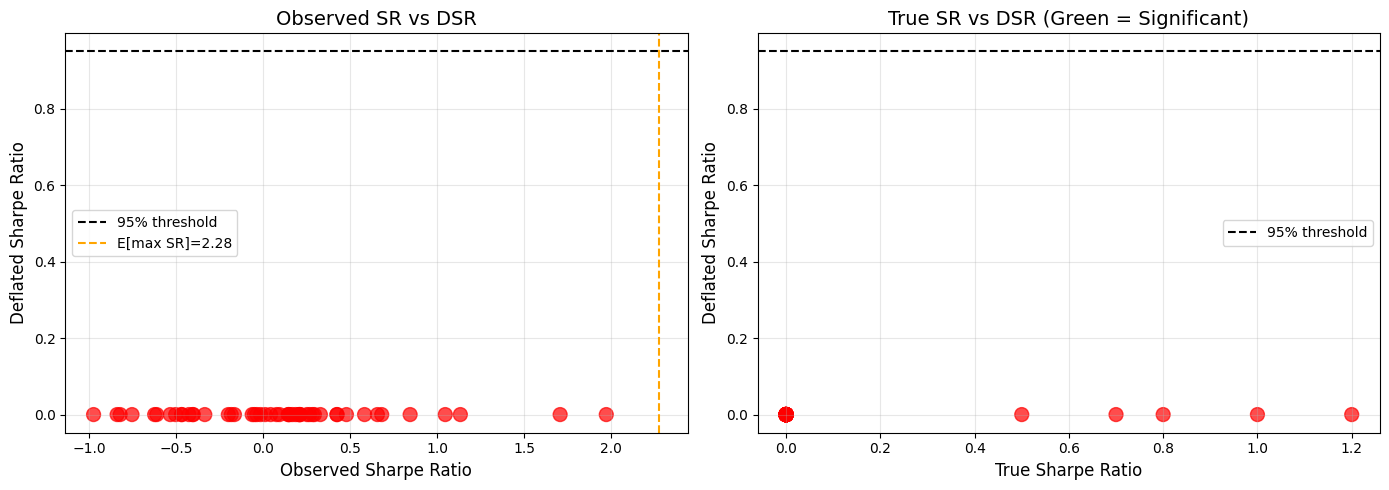

In [23]:
# Visualize: True SR vs DSR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Observed SR vs DSR
colors = ['green' if sig else 'red' for sig in results_df['is_significant']]
axes[0].scatter(results_df['observed_sr'], results_df['dsr'], c=colors, alpha=0.7, s=100)
axes[0].axhline(y=0.95, color='black', linestyle='--', label='95% threshold')
axes[0].axvline(x=dsr_evaluator.expected_max_sr, color='orange', linestyle='--', 
                label=f'E[max SR]={dsr_evaluator.expected_max_sr:.2f}')
axes[0].set_xlabel('Observed Sharpe Ratio', fontsize=12)
axes[0].set_ylabel('Deflated Sharpe Ratio', fontsize=12)
axes[0].set_title('Observed SR vs DSR', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: True SR vs DSR
axes[1].scatter(results_df['true_sr'], results_df['dsr'], c=colors, alpha=0.7, s=100)
axes[1].axhline(y=0.95, color='black', linestyle='--', label='95% threshold')
axes[1].set_xlabel('True Sharpe Ratio', fontsize=12)
axes[1].set_ylabel('Deflated Sharpe Ratio', fontsize=12)
axes[1].set_title('True SR vs DSR (Green = Significant)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Summary statistics
n_true_positive = len(results_df[(results_df['is_significant']) & (results_df['true_sr'] > 0)])
n_false_positive = len(results_df[(results_df['is_significant']) & (results_df['true_sr'] == 0)])
n_true_negative = len(results_df[(~results_df['is_significant']) & (results_df['true_sr'] == 0)])
n_false_negative = len(results_df[(~results_df['is_significant']) & (results_df['true_sr'] > 0)])

print("\nClassification Results (DSR > 0.95 threshold)")
print("="*50)
print(f"True Positives:  {n_true_positive:3d} (Real strategies correctly identified)")
print(f"False Positives: {n_false_positive:3d} (Noise strategies incorrectly flagged)")
print(f"True Negatives:  {n_true_negative:3d} (Noise strategies correctly rejected)")
print(f"False Negatives: {n_false_negative:3d} (Real strategies incorrectly rejected)")
print()
if n_true_positive + n_false_positive > 0:
    precision = n_true_positive / (n_true_positive + n_false_positive)
    print(f"Precision: {precision:.2%}")
if n_true_positive + n_false_negative > 0:
    recall = n_true_positive / (n_true_positive + n_false_negative)
    print(f"Recall:    {recall:.2%}")


Classification Results (DSR > 0.95 threshold)
True Positives:    0 (Real strategies correctly identified)
False Positives:   0 (Noise strategies incorrectly flagged)
True Negatives:   45 (Noise strategies correctly rejected)
False Negatives:   5 (Real strategies incorrectly rejected)

Recall:    0.00%


## 11. Probability of Backtest Overfitting (PBO)

The **Probability of Backtest Overfitting (PBO)** uses **Combinatorially Symmetric Cross-Validation (CSCV)** to directly estimate the probability that a selected strategy is overfit.

### How CSCV Works:
1. Split the data into $N$ groups (e.g., 16)
2. Generate all symmetric partitions into training (S) and testing ($\bar{S}$) sets
3. For each partition:
   - Find the best strategy in-sample (training set)
   - Evaluate its rank out-of-sample (test set)
4. Compute $\lambda$ = relative rank of best IS strategy in OOS
5. PBO = proportion of partitions where $\lambda > 0.5$ (i.e., below median OOS)

In [25]:
from ml4am.testing_set_overfitting import CSCV, probability_of_overfitting

In [26]:
# CSCV uses combinatorial partitions
# For N groups, number of partitions = C(N, N/2) / 2

for n_groups in [4, 8, 10, 16]:
    cscv = CSCV(n_groups=n_groups)
    print(f"N={n_groups:2d} groups -> {cscv.n_partitions:,} partitions")

N= 4 groups -> 3 partitions
N= 8 groups -> 35 partitions
N=10 groups -> 126 partitions
N=16 groups -> 6,435 partitions


### Example: Detecting Overfitting with PBO

In [27]:
# Case 1: All strategies are pure noise
np.random.seed(42)
n_obs, n_strategies = 1000, 50

# Generate random returns (no signal)
returns_noise = np.random.randn(n_obs, n_strategies) * 0.01

# Compute PBO
result_noise = probability_of_overfitting(returns_noise, n_groups=8)

print("Case 1: All Noise Strategies")
print("="*50)
print(f"PBO: {result_noise['pbo']:.1%}")
print(f"In-sample mean SR:  {result_noise['is_performance_mean']:.3f}")
print(f"Out-of-sample mean SR: {result_noise['oos_performance_mean']:.3f}")
print(f"\nInterpretation: High PBO ({result_noise['pbo']:.0%}) indicates the")
print("selected strategy is likely overfit and won't perform OOS.")

Case 1: All Noise Strategies
PBO: 71.4%
In-sample mean SR:  1.574
Out-of-sample mean SR: -0.205

Interpretation: High PBO (71%) indicates the
selected strategy is likely overfit and won't perform OOS.


In [28]:
# Case 2: Some strategies have real signal
returns_signal = np.random.randn(n_obs, n_strategies) * 0.01
returns_signal[:, :5] += 0.001  # Add 0.1% daily return to 5 strategies

result_signal = probability_of_overfitting(returns_signal, n_groups=8)

print("Case 2: 5 Strategies with Signal")
print("="*50)
print(f"PBO: {result_signal['pbo']:.1%}")
print(f"In-sample mean SR:  {result_signal['is_performance_mean']:.3f}")
print(f"Out-of-sample mean SR: {result_signal['oos_performance_mean']:.3f}")
print(f"\nInterpretation: Low PBO ({result_signal['pbo']:.0%}) indicates the")
print("selected strategy likely has genuine predictive power.")

Case 2: 5 Strategies with Signal
PBO: 5.7%
In-sample mean SR:  2.128
Out-of-sample mean SR: 1.106

Interpretation: Low PBO (6%) indicates the
selected strategy likely has genuine predictive power.


In [29]:
# Compare PBO across different scenarios
scenarios = [
    ("All noise", 0),
    ("Weak signal (0.05%)", 0.0005),
    ("Medium signal (0.1%)", 0.001),
    ("Strong signal (0.2%)", 0.002),
]

print(f"{'Scenario':<25} {'PBO':>8} {'IS SR':>10} {'OOS SR':>10}")
print("-"*55)

for name, signal in scenarios:
    returns = np.random.randn(n_obs, n_strategies) * 0.01
    returns[:, :5] += signal
    result = probability_of_overfitting(returns, n_groups=8)
    print(f"{name:<25} {result['pbo']:>7.1%} {result['is_performance_mean']:>10.2f} {result['oos_performance_mean']:>10.2f}")

Scenario                       PBO      IS SR     OOS SR
-------------------------------------------------------
All noise                   40.0%       1.59       0.12
Weak signal (0.05%)         45.7%       1.71       0.07
Medium signal (0.1%)         0.0%       2.51       1.65
Strong signal (0.2%)         0.0%       3.97       3.10


### Visualizing PBO: The Stochastic Dominance Curve

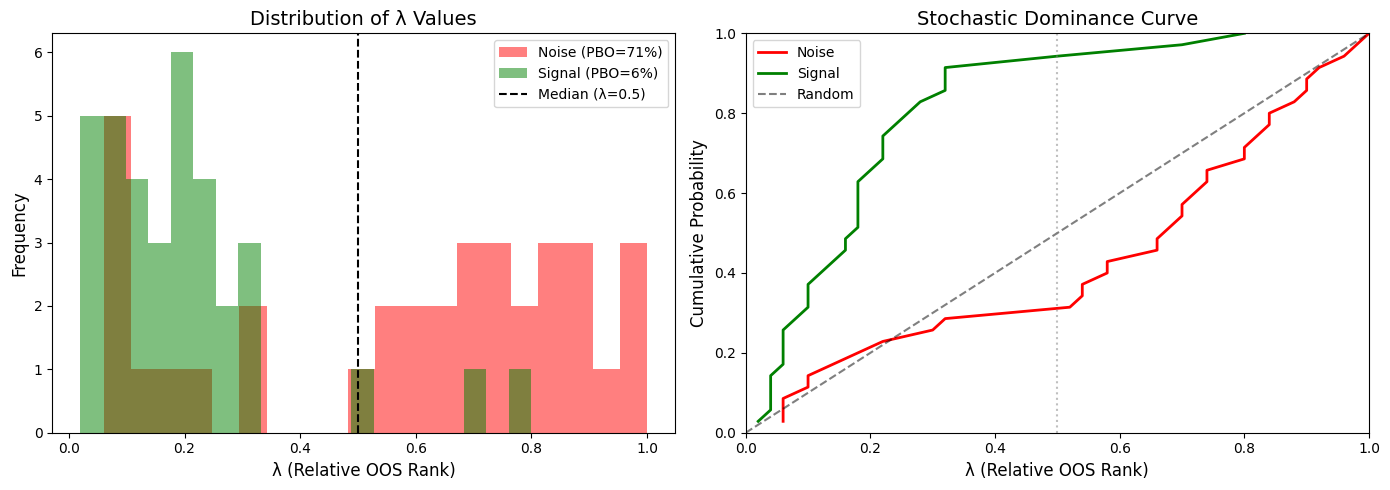

In [30]:
# Visualize the lambda distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Noise case
cscv_noise = CSCV(n_groups=8)
cscv_noise.fit(returns_noise)
x_noise, y_noise = cscv_noise.get_stochastic_dominance()

# Signal case  
cscv_signal = CSCV(n_groups=8)
cscv_signal.fit(returns_signal)
x_signal, y_signal = cscv_signal.get_stochastic_dominance()

# Plot 1: Lambda histogram
axes[0].hist(cscv_noise.lambda_values, bins=20, alpha=0.5, label=f'Noise (PBO={cscv_noise.pbo:.0%})', color='red')
axes[0].hist(cscv_signal.lambda_values, bins=20, alpha=0.5, label=f'Signal (PBO={cscv_signal.pbo:.0%})', color='green')
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Median (λ=0.5)')
axes[0].set_xlabel('λ (Relative OOS Rank)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of λ Values', fontsize=14)
axes[0].legend()

# Plot 2: Stochastic dominance
axes[1].plot(x_noise, y_noise, 'r-', linewidth=2, label='Noise')
axes[1].plot(x_signal, y_signal, 'g-', linewidth=2, label='Signal')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[1].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[1].set_xlabel('λ (Relative OOS Rank)', fontsize=12)
axes[1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1].set_title('Stochastic Dominance Curve', fontsize=14)
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Interpreting PBO Results

| PBO Value | Interpretation |
|-----------|----------------|
| < 5% | Strong evidence of genuine strategy |
| 5-25% | Acceptable, but use caution |
| 25-50% | Concerning - likely some overfitting |
| > 50% | High probability of overfitting - do not deploy |

**Key insight**: A PBO > 50% means the best in-sample strategy performs *below median* out-of-sample more often than not.

## 12. Key Takeaways

1. **Multiple testing inflates performance**: The more strategies you test, the higher the expected maximum SR, even with zero true performance.

2. **Use DSR, not just SR**: The Deflated Sharpe Ratio accounts for multiple testing, non-normality, and sample length.

3. **Compute PBO with CSCV**: The Probability of Backtest Overfitting provides a direct estimate of overfitting probability.

4. **Longer backtests are more reliable**: Short backtests require much higher observed SRs to be statistically significant.

5. **Be honest about trial count**: Both DSR and PBO require knowing how many strategies were tested.

6. **Non-normality matters**: Fat tails (high kurtosis) and skewness affect the statistical reliability of the Sharpe Ratio.

7. **Autocorrelation inflates SR**: Positive autocorrelation in returns makes the SR appear better than it is.

## References

- Lopez de Prado, M. (2020). *Machine Learning for Asset Managers*. Cambridge University Press.
- Bailey, D.H. and Lopez de Prado, M. (2014). "The Deflated Sharpe Ratio: Correcting for Selection Bias, Backtest Overfitting and Non-Normality", *Journal of Portfolio Management*, 40(5).
- Bailey, D.H., Borwein, J., Lopez de Prado, M., and Zhu, Q.J. (2017). "The Probability of Backtest Overfitting", *Journal of Computational Finance*, 20(4).